# Kaggle Fake News (Only Title) Detection using Long Short Term Memory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load the Dataset

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d samrat96/fake-news-detection

fake-news-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fake-news-detection.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Data Preprocessing

In [7]:
# Checking for NaN values
df.isna().sum() # There are NaN value

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
# Checking for Duplicates
df.duplicated().sum()

0

In [9]:
# Dropping NaN values
df = df.dropna()

In [10]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
X = df.drop('label', axis=1)

In [12]:
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [13]:
y = df['label']

In [14]:
y

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 18285, dtype: int64

In [15]:
X.shape

(18285, 4)

In [16]:
y.shape

(18285,)

In [17]:
X.columns

Index(['id', 'title', 'author', 'text'], dtype='object')

In [18]:
# Finding the max words that a
maxlen_text = {'highest' : [0, 0]}
for index, word in enumerate(X['text']):
  if len(word.split()) > maxlen_text['highest'][1]:
    maxlen_text['highest'][1] = len(word.split())
    maxlen_text['highest'][0] = index
print(maxlen_text)

{'highest': [11907, 24234]}


In [19]:
X['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [20]:
# X['Combined_Text'] = X['title'] + '   ' +  X['text']
# X = X.drop(['title', 'text'], axis=1)

In [21]:
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


## Importing Deep Learning Libraries

In [22]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Embedding, Dropout
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
# vocab size
vocab_size = 5000

### One Hot Representation

In [24]:
text = X.copy()
text.reset_index(inplace=True)

In [25]:
import re
import nltk
from nltk.corpus import stopwords

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Preprocessing of the Combined_Text column in X
* Removing Special Characters replacing by ' '
* Converting to Lower Case
* Applying Stemming

In [27]:
## Data Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
stop_words = set(stopwords.words('english'))
for i in range(0, len(text)):
  review = re.sub('[^a-zA-Z0-9]', ' ', text['title'][i]) # Removing Special Characters
  review = review.lower()
  review = review.split()
  # review = review[:300]
  review = [ps.stem(word) for word in review if word.lower() not in stop_words]
  review = ' '.join(review)
  corpus.append(review)

In [28]:
corpus[0]

'hous dem aid even see comey letter jason chaffetz tweet'

In [29]:
corpus[11907]

'hard work american vs govern parasit'

In [30]:
# One-HOT Encoding
encoded_corpus = [one_hot(review, vocab_size) for review in corpus]

In [31]:
encoded_corpus[0]

[11, 33, 4038, 1724, 3661, 1152, 4289, 4417, 1515, 3136]

### Applying Pad Sequences

In [32]:
sent_length = 20
padded_docs  = pad_sequences(sequences=encoded_corpus, maxlen=sent_length, padding='pre')

In [33]:
padded_docs

array([[   0,    0,    0, ..., 4417, 1515, 3136],
       [   0,    0,    0, ...,  490, 3885, 1727],
       [   0,    0,    0, ..., 4626, 2033, 4328],
       ...,
       [   0,    0,    0, ..., 2708, 3625, 1342],
       [   0,    0,    0, ..., 2888,  644, 1019],
       [   0,    0,    0, ..., 2866, 1401, 4613]], dtype=int32)

In [34]:
len(padded_docs)

18285

In [35]:
X_final = np.array(padded_docs)
y_final = np.array(y)

In [36]:
X_final.shape, y_final.shape

((18285, 20), (18285,))

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [38]:
# Converting (N,) to (N, 1)
import numpy as np
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(14628, 20)
(14628, 1)
(3657, 20)
(3657, 1)


## Creating the Model

In [40]:
embedding_output_features = 40
model = Sequential()
model.add(Embedding(vocab_size, embedding_output_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
__________________________________________________

In [42]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
229/229 [==============================] - 26s 71ms/step - loss: 0.2880 - accuracy: 0.8664 - val_loss: 0.2004 - val_accuracy: 0.9136
Epoch 2/10
229/229 [==============================] - 6s 25ms/step - loss: 0.1415 - accuracy: 0.9443 - val_loss: 0.1972 - val_accuracy: 0.9155
Epoch 3/10
229/229 [==============================] - 3s 13ms/step - loss: 0.1043 - accuracy: 0.9629 - val_loss: 0.2410 - val_accuracy: 0.9128
Epoch 4/10
229/229 [==============================] - 3s 13ms/step - loss: 0.0840 - accuracy: 0.9699 - val_loss: 0.2303 - val_accuracy: 0.9147
Epoch 5/10
229/229 [==============================] - 2s 10ms/step - loss: 0.0693 - accuracy: 0.9757 - val_loss: 0.2400 - val_accuracy: 0.9054
Epoch 6/10
229/229 [==============================] - 3s 15ms/step - loss: 0.0531 - accuracy: 0.9825 - val_loss: 0.3768 - val_accuracy: 0.8991
Epoch 7/10
229/229 [==============================] - 3s 12ms/step - loss: 0.0439 - accuracy: 0.9856 - val_loss: 0.4012 - val_accuracy: 0.906

## Ploting Loss and accuracy during training

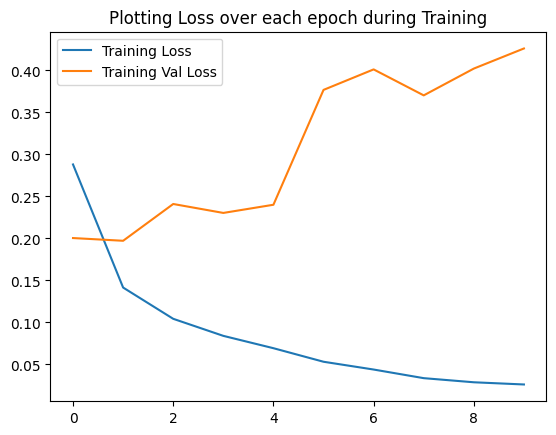

In [44]:
plt.title('Plotting Loss over each epoch during Training')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Training Val Loss')
plt.legend()
plt.show()

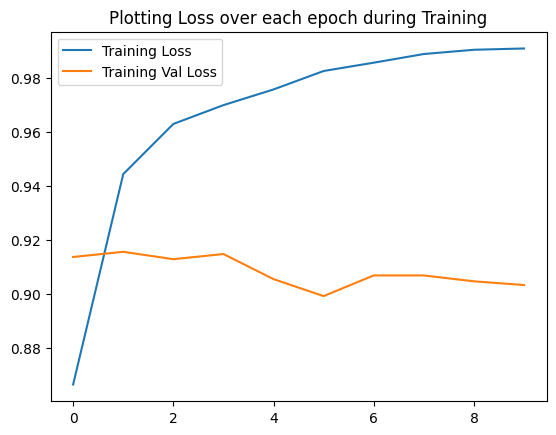

In [45]:
plt.title('Plotting Loss over each epoch during Training')
plt.plot(history.history['accuracy'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='Training Val Loss')
plt.legend()
plt.show()

## Evaluating Performence over the testing data

In [46]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

115/115 [==============================] - 1s 3ms/step


In [47]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_test, y_pred)

array([[1876,  206],
       [ 148, 1427]])

In [49]:
accuracy_score(y_test, y_pred)

0.9031993437243643

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2082
           1       0.87      0.91      0.89      1575

    accuracy                           0.90      3657
   macro avg       0.90      0.90      0.90      3657
weighted avg       0.90      0.90      0.90      3657



In [72]:
model.save('fakeNews_BidirectionalLSTM_model.h5')

## Testing with Test.csv

In [51]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [52]:
# Checking for NaN values
test_df.isna().sum() # There are NaN value

id          0
title     122
author    503
text        7
dtype: int64

In [53]:
test_df.duplicated().sum()

0

In [54]:
test_df.columns

Index(['id', 'title', 'author', 'text'], dtype='object')

In [55]:
test_df = test_df.dropna()

In [56]:
testX = test_df

In [57]:
testX.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
6,20806,Pelosi Calls for FBI Investigation to Find Out...,Pam Key,"Sunday on NBC’s “Meet the Press,” House Minori..."


In [58]:
message = testX.copy()
message.reset_index(inplace=True)

In [59]:
## Data Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
testcorpus = []
stop_words = set(stopwords.words('english'))
for i in range(0, len(message)):
  review = re.sub('[^a-zA-Z0-9]', ' ', message['title'][i]) # Removing Special Characters
  review = review.lower()
  review = review.split()
  # review = review[:300]
  review = [ps.stem(word) for word in review if word.lower() not in stop_words]
  review = ' '.join(review)
  testcorpus.append(review)

In [60]:
testcorpus[0]

'specter trump loosen tongu purs string silicon valley new york time'

In [61]:
# One-HOT Encoding
encoded_corpus = [one_hot(review, vocab_size) for review in corpus]

In [62]:
encoded_corpus[0]

[11, 33, 4038, 1724, 3661, 1152, 4289, 4417, 1515, 3136]

In [63]:
sent_length = 20
padded_docs  = pad_sequences(sequences=encoded_corpus, maxlen=sent_length, padding='pre')

In [64]:
padded_docs

array([[   0,    0,    0, ..., 4417, 1515, 3136],
       [   0,    0,    0, ...,  490, 3885, 1727],
       [   0,    0,    0, ..., 4626, 2033, 4328],
       ...,
       [   0,    0,    0, ..., 2708, 3625, 1342],
       [   0,    0,    0, ..., 2888,  644, 1019],
       [   0,    0,    0, ..., 2866, 1401, 4613]], dtype=int32)

In [65]:
len(padded_docs)

18285

In [66]:
testX_final = np.array(padded_docs)

In [67]:
test_y_prob = model.predict(testX_final)

572/572 [==============================] - 2s 3ms/step


In [68]:
test_y_prob

array([[4.3963093e-01],
       [1.6050557e-04],
       [9.9935788e-01],
       ...,
       [2.4070668e-04],
       [5.5690175e-01],
       [9.9780709e-01]], dtype=float32)

In [69]:
test_y_pred = (test_y_prob > 0.5).astype(int)

In [70]:
test_y_pred

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [71]:
test_y_pred[:20]

array([[0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0]])